## Tutorial B8: Seqlets

> deep_lift_shap/saturation mutagenesis

After calculating attribution scores, a common goal is to identify *spans* that drive model predictions and, potentially, form protein binding sites. These spans have been called "seqlets" because they refer to short sequences and are distinct from k-mers or motifs because they specifically refer to spans of high-attribution characters in a sequence regardless of nucleotide composition. Usually, seqlets form the basis of subsequent algorithms that cluster seqlets (such as TF-MoDISco) into repeating patterns but they can also be used by themselves to get a sense for what patterns might be driving predictions in a sequence or if you would like to develop your own motif discovery algorithm!

Like with our other tutorials, let's begin by loading the Beluga model.

In [1]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

To demonstrate seqlet calling, we need clean attribution scores. As demonstrated in the marginalization tutorial, we can get clean attributions for one or more motifs by generating a set of background sequences, substituting in the motifs of interest, and using the background sequences themselves as a reference instead of dinucleotide shuffling just one sequence. Let's do that here with two AP-1 motifs and a YY1 motif and run DeepLIFT/SHAP against a DNase target.

In [2]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import multisubstitute
from tangermeme.deep_lift_shap import deep_lift_shap

X = random_one_hot((100, 4, 2000), random_state=0).type(torch.float32)  
X = multisubstitute(X, ["GTGACTCATC", "GTGACTCATC", "AACATCCGCC"], [25, 25])
X_attr = deep_lift_shap(model, X, device='cpu', n_shuffles=1, target=57, random_state=0).mean(dim=0, keepdims=True)

Remember that the reason this works is because we are averaging the attributions across many backgrounds. Next, we can visualize the attributions to make sure that we are identifying the patterns we inserted in.

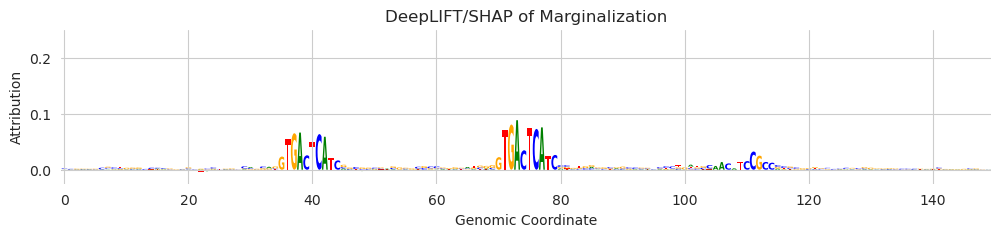

In [3]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 925:1075], ax=ax)
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Looks like the two AP-1 motifs are being pulled out neatly and the YY1 motif is only somewhat informative.

Next, we turn to the task of identifying the boundaries of these spans. This is the task of seqlet calling, where the precise boundaries of these high attribution spans is determined. One method for identifying seqlets is the method employed by TF-MoDISco where the nucleotide-specific attribution values are replaced with sums of attribution values across a fixed span starting at that nucleotide, a null distribution of attribution values is calculated from these sums, and, at a very high level, seqlets are called based on the FDR score compared with these null distribution.

We can run this seqlet calling method using the `tfmodisco_seqlets` function. This function takes in an attribution track -- which should not contain hypothetical attributions -- and returns a set of seqlets with positive attribution and a set of seqlets with negative attributions as pandas DataFrames with the same format as the other motif calling methods.

In [4]:
from tangermeme.seqlet import tfmodisco_seqlets

pos_seqlets, neg_seqlets = tfmodisco_seqlets(X_attr)
pos_seqlets.head()

,example_idx,start,end,strand,score,attr,seq
0,0,980,1021,*,0.642675,0.642675,ATGGGGTGACTCATCCCGTGG
1,0,944,985,*,0.490668,0.490668,CAGCAGGTGACTCATCGGCGG
2,0,1012,1053,*,0.218845,0.218845,CCTGATGCAACATCCGCCCCG
3,0,912,953,*,0.047066,0.047066,GGCCCGTGTCGCTGGGCCCCG
4,0,1033,1074,*,0.045792,0.045792,CGGGGCCCCGCGGGGGGCCCG


It looks like the attribution scores drop significantly after the third seqlet. This is likely because the first three seqlets correspond to the three known motifs that we inserted into the sequence and the ones after that are just false positives. Something to note about this approach to seqlet calling is that it assumes a minimum number of regions will be seqlets and so will adaptively change the thresholds internally to make sure that number of seqlets are called. This means that the method can overcall seqlets when examples do not have enough going on in them. For TF-MoDISco this is not a big problem because the seqlets are more rigorously filtered in subsequent steps, but you may need to implement similar filtering (e.g., based on attribution scores) to remove these spuriously called seqlets.

As a note, the "score" and "attr" columns are the same to make the format of this dataframe the same as the other motif calling methods where there may be a difference between the two. For example, when running FIMO, the score is based solely on how well the underlying sequences match and "attr" is just the sum of the attribution score in that span. Here, because the attribution score is what is being used to call seqlets, the two are the same.

Once we have a set of seqlets, we would probably like to visualize the boundaries on the logo plot we made before. Fortunately, the same `plot_logo` function we have been using to plot logos can also accept annotation dataframes that indicate regions to highlight. These dataframes must be in the format seen above and you must pass in `start` and `end` rather than subsetting the length of the attribution tensor. This will make sure that the attributions and the boundaries in the annotations are aligned. After all, if you subsetted the length of the attribution tensor, the function would have no idea which boundaries in the annotation fell within this new tensor.

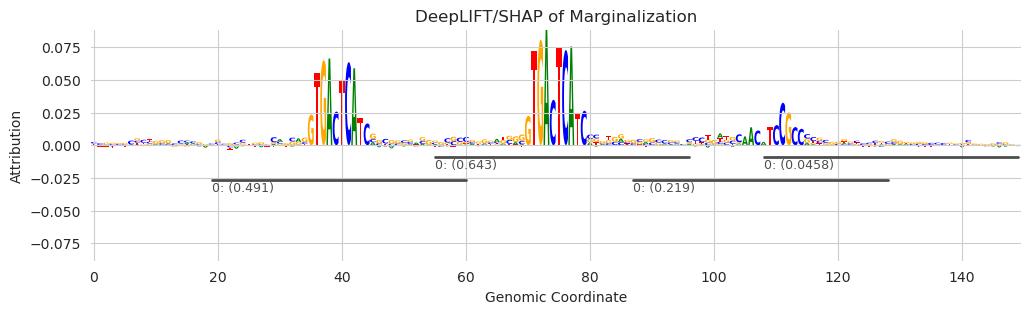

In [5]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=pos_seqlets)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Looks like all three of the motifs we added in are being underlined by the seqlet caller. Each line is drawn from the start to the end of the annotation assuming that the start and end of the annotation fall within the provided window. The text under the line is the name of the element (just the example index by default from the seqlet caller) and the score value for that annotation. 

You might notice that the boundaries seem a little bit... offset... with a longer span to the left of the seqlet than to the right. This is because, internally, the attribution at each position is replaced with the sum of the attributions starting at that position and moving to the right. This means that the chosen position for each seqlet is the left side of the seqlet. From this chosen position, a fixed-width span is chosen on either end.

By default, the TF-MoDISco seqlet caller calls seqlets that are quite long. This is because the TF-MoDISco algorithm uses a similar score based on alignment and so it is better to have more context than it is to miss something important in the seqlet. If you would like to change the width you can alter the `window_size` and `flank` arguments. The `window_size` argument defines how many positions to the right to sum over when replacing the position-specific attribution, and the `flank` argument defines the additional number of nucleotides to add to the seqlet for padding.

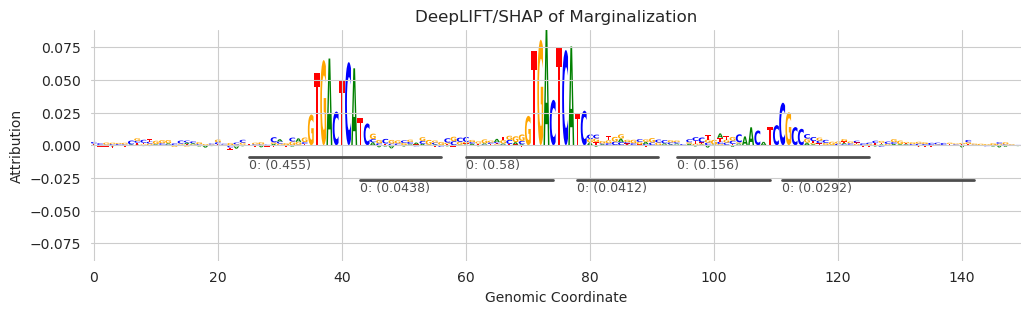

In [6]:
pos_seqlets, neg_seqlets = tfmodisco_seqlets(X_attr, window_size=11)

plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=pos_seqlets)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

By decreasing the window size to 11 we get shorter seqlets but also we begin to get an overcalling of low-attribution seqlets. This is largely because, when a seqlet is called, a window surrounding the calling position is blanked out, preventing additional seqlets from being called at this position. When the window size is decreased, additional seqlets may be called that pick up on the flanking nucleotides that do not themselves have very high attribution scores but have relatively high attributions given a background sequence. However, the seqlets called for the known patterns are still several times stronger than any of the overcalled seqlets.

Taken together, seqlet calling and plotting of these annotations can be a powerful tool for understanding what your model is picking up on when it makes predictions. As we will see in later notebooks, the automatic partitioning of the genome into units that drive predictions will be a valuable step for many downstream processes that can be useful in summarizing the features driving predictions globally.